In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [61]:
def str_to_float(number):
    num = number.split(',')
    if len(num)==1 :
        return float(num[0])
    else :
        return (float(num[0]+'.'+num[1]))

str_to_float_v = np.vectorize(str_to_float)

In [89]:
def new_name(path,ext):
    componants = path.split("\\")
    name = componants[-1]
    name2 = name[:-4]
    return (name2 + "." + ext)

In [90]:
def plot_csv(path):
    data = pd.read_csv(path, index_col="Bal",delimiter=";")
    columns = data.columns
    data_to_plot = columns[2]
    
    val = str_to_float_v(data[data_to_plot].values)

    plt.figure()
    plt.plot(val)
    plt.xlabel("Balayage")
    plt.ylabel(data_to_plot)
    plt.grid()
    plt.savefig('Plot\\'+new_name(path,'png'))
    plt.show()

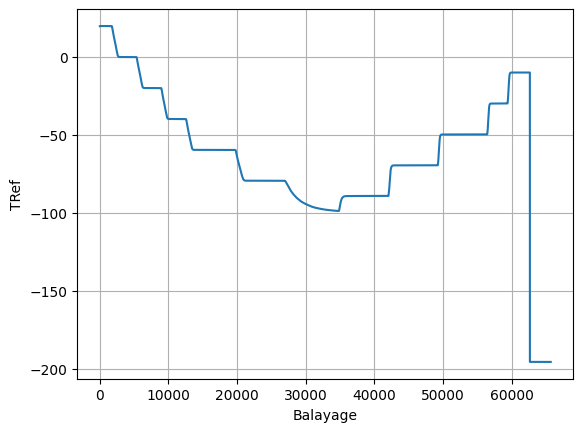

In [91]:
plot_csv("Data\Calne.csv")